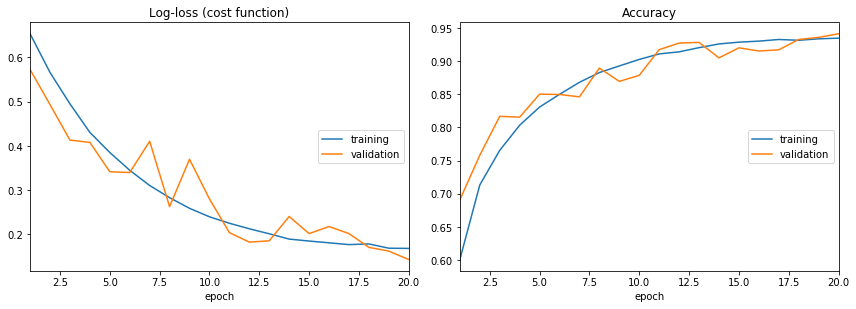

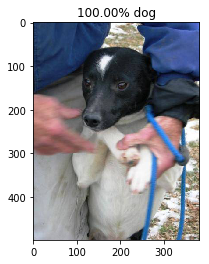

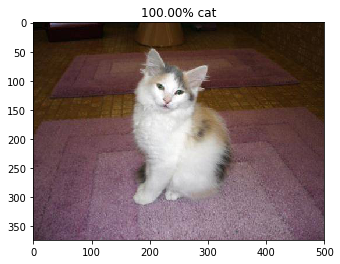

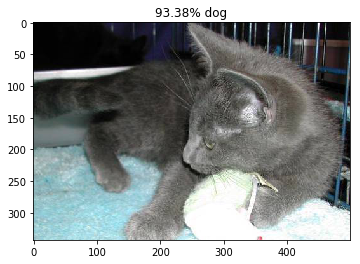

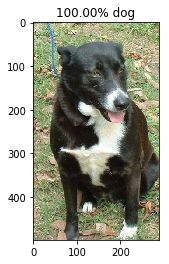

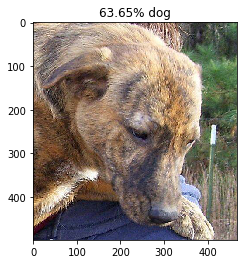

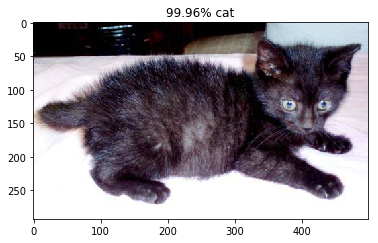

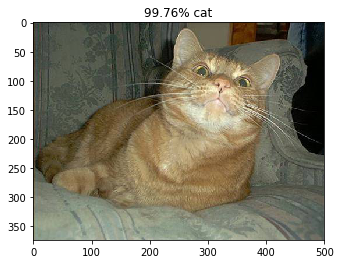

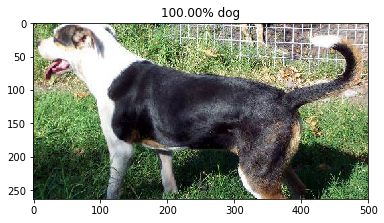

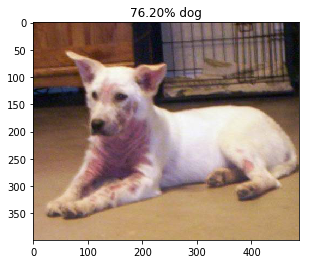

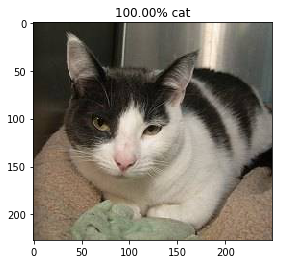

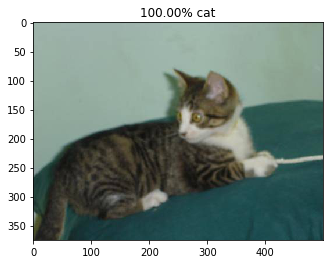

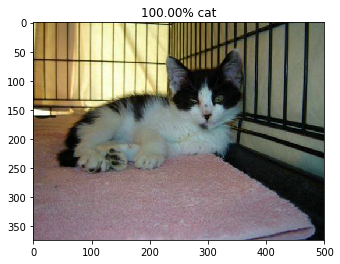

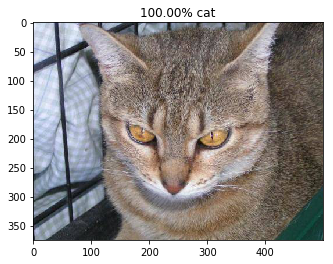

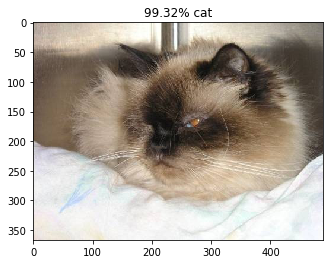

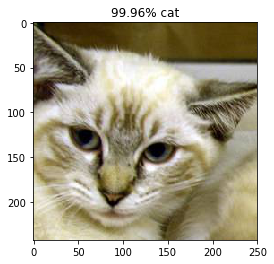

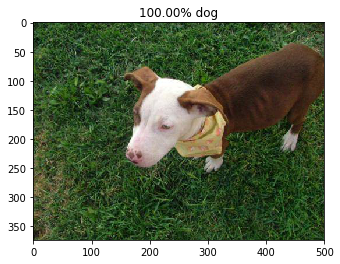

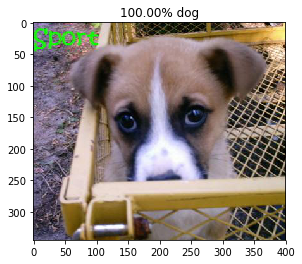

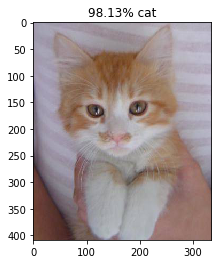

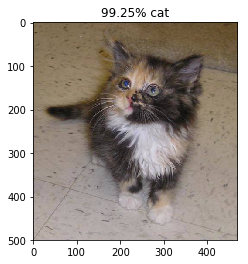

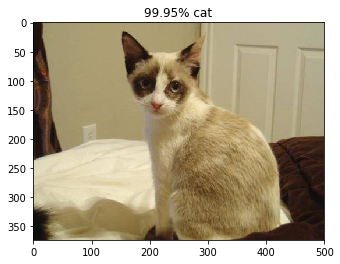

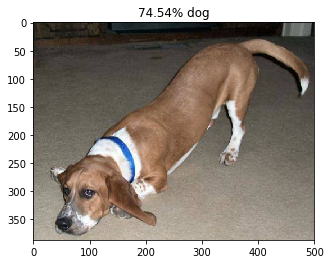

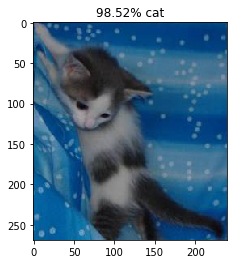

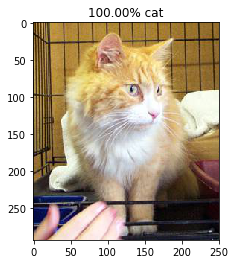

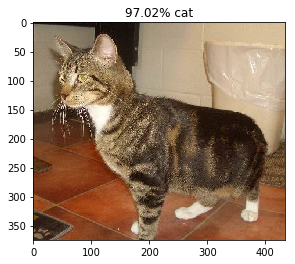

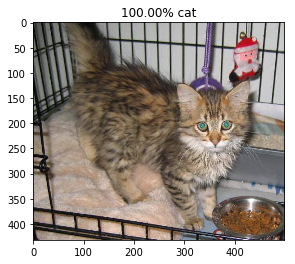

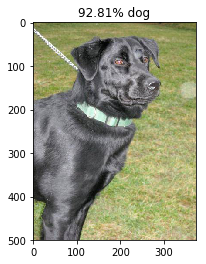

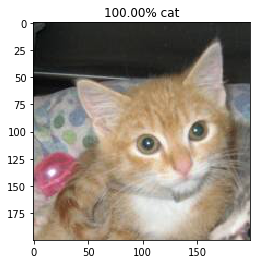

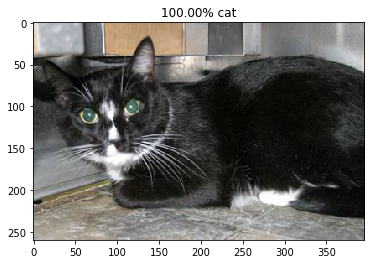

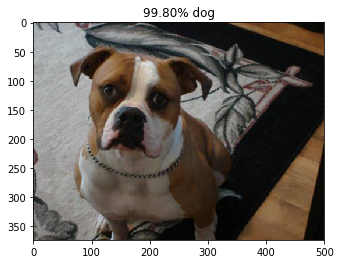

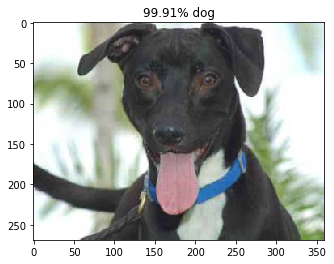

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger

GOOGLE_COLAB = False
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"

if GOOGLE_COLAB:
    !pip install livelossplot
from livelossplot import PlotLossesKeras

# Data
path = ""
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive/')
    path = "/content/drive/My Drive/image_classifier/"
training_data_dir = path + "data/training" # 10 000 * 2
validation_data_dir = path + "data/validation" # 2 500 * 2
test_data_dir = path + "data/test" # 12 500

# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 32
TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

# Model 5
model = Sequential()

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))
    
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)
model.save_weights(MODEL_FILE)

# Testing
open(TEST_FILE,"w")
probabilities = model.predict_generator(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    with open(TEST_FILE,"a") as fh:
        fh.write(str(probability[0]) + " for: " + image_path + "\n")
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()

if GOOGLE_COLAB:
    files.download(MODEL_SUMMARY_FILE)
    files.download(MODEL_FILE)
    files.download(TRAINING_LOGS_FILE)
    files.download(TEST_FILE)